In [1]:
from DataFetcher import DataFetcher
from USTs import USTs
from Curves import ParCurves, calibrate_mles
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import plotly.graph_objects as go

In [2]:
auctions = DataFetcher().fetch_auction_data()
prices = DataFetcher().fetch_historical_UST_data(date=datetime.datetime(year=2025, month=6, day=26))
usts = USTs(auction_data=auctions,price_data=prices)
ust_set = usts.get_current_UST_set(settlement_date=datetime.datetime(2025, 6, 27),
                                   get_ytms=True,
                                   include_FRNs=False,
                                   include_TIPS=False,
                                   include_outstanding=False)
ust_set

Merged auction and price data successfully
No missing or excess data
All CUSIPs are identical between DataFrames


,Security type,Rate,Maturity date,End of day,Security term,Issue date,Years to maturity,UST label,EOD YTM,Duration,Rank
Cusip,,,,,,,,,,,
912828XZ8,Note,2.750,2025-06-30,99.968750,7-Year,2018-07-02,0.010959,2.750% Jun-25,6.559941,0.007980,84
91282CHL8,Note,4.625,2025-06-30,99.968750,2-Year,2023-06-30,0.010959,4.625% Jun-25,8.400867,0.007910,24
912828ZW3,Note,0.250,2025-06-30,99.968750,5-Year,2020-06-30,0.010959,0.250% Jun-25,4.078317,0.008077,58
912797PU5,Bill,0.000,2025-07-01,99.954778,17-Week,2025-03-04,0.013699,0.000% Jul-25,4.128374,0.016467,17
912797NX1,Bill,0.000,2025-07-03,99.932333,26-Week,2025-01-02,0.019178,0.000% Jul-25,4.119197,0.016240,19
...,...,...,...,...,...,...,...,...,...,...,...
912810UA4,Bond,4.625,2054-05-15,96.687500,30-Year,2024-05-15,28.904110,4.625% May-54,4.840632,15.526043,5
912810UC0,Bond,4.250,2054-08-15,90.906250,30-Year,2024-08-15,29.156164,4.250% Aug-54,4.833356,15.708498,4
912810UE6,Bond,4.500,2054-11-15,94.875000,30-Year,2024-11-15,29.408219,4.500% Nov-54,4.829236,15.752849,3


In [3]:
filtered_set = ust_set[(ust_set['Years to maturity'] > 90/365) & (ust_set['Security type'] != 'Bill') & (ust_set['Rank'] > 2)] # Removing T-Bills and OTR securities

curve_builder = ParCurves(filtered_set)
spline_x, spline_y = curve_builder.univariate_spline(smoothness=0.2, return_data=True)
bspline_x, bspline_y = curve_builder.Bspline_with_knots(knots=[0.5, 1, 2, 3, 5, 7, 8, 9, 10, 15, 20, 25])
mles_curve, _ = calibrate_mles(maturities=filtered_set['Years to maturity'].to_numpy(), # Merrill Lynch Exponential Spline (parametric model)
               yields=filtered_set['EOD YTM'].to_numpy(),
               N=9,
               overnight_rate=4.33)
mles_x = np.arange(0.25, 30, 1/365)
mles_y = mles_curve.theoretical_yields(maturities=mles_x)

fig = go.Figure()
hovertemplate = (
    "<b>CUSIP:</b> %{customdata[0]}<br>"+
    "<b>YTM:</b> %{y:.3%}<br>"+
    "<b>Coupon</b> %{customdata[2]}<br>"+
    "<b>Price:</b> %{customdata[4]:.4f}<br>"+
    "<b>Duration:</b> %{customdata[10]:.2f}<br>"+
    "<b>Maturity date:</b> %{customdata[3]|%Y-%m-%d}<br>"+
    "<b>Issue date:</b> %{customdata[6]|%Y-%m-%d}<br>"
)

years = ['2', '3', '5', '7', '10', '20', '30']
terms = [tenor + '-Year' for tenor in years] # Ordered list
for tenor in terms:
    subset = ust_set[(ust_set['Security term'] == tenor) & (ust_set['Years to maturity'] > 90/365)].reset_index(drop=False)
    custom_data = subset.to_numpy()
    fig.add_trace(go.Scatter(
        x=subset['Years to maturity'],
        y=subset['EOD YTM']/100,
        mode='markers',
        name=tenor,
        hovertemplate=hovertemplate,
        customdata=custom_data,
        text=subset['EOD YTM'],
        marker=dict(
            size=8
        )
    ))
fig.add_trace(go.Scatter(
    x=spline_x,
    y=spline_y/100,
    mode='lines',
    name='Smoothed cubic spline'
))
fig.add_trace(go.Scatter(
    x=mles_x,
    y=mles_y/100,
    mode='lines',
    name='Merrill Lynch Exponential Spline',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=bspline_x,
    y=bspline_y/100,
    mode='lines',
    name='Cubic B-spline with knots',
    line=dict(width=3)
))
fig.update_layout(
    title='US Treasury Yield Curve',
    width=1400,
    height=600,
    margin=dict(l=20, r=20, t=50, b=20),
    xaxis_title='Years to maturity',
    yaxis_title='End-of-Day Yield to Maturity (YTM)',
    yaxis_tickformat='.2%',
    legend_title_text='Security Tenors',
    template='plotly_dark'
)
fig.show()

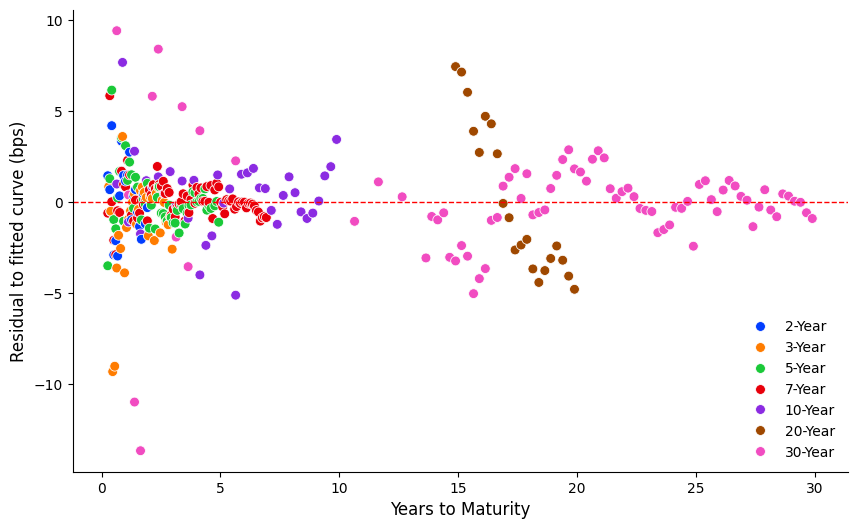

In [4]:
bond_df_with_residuals = usts.get_residuals(curve=(bspline_x, bspline_y), return_full_df=True, plot_residuals=True)

In [5]:
fig = go.Figure()
data = bond_df_with_residuals[(bond_df_with_residuals['Duration'] > 9) & (bond_df_with_residuals['Duration'] < 14)]
tenors = ['20-Year', '30-Year']

for tenor in tenors:
    plot_data = data[data['Security term'] == tenor]
    fig.add_trace(go.Scatter(
        x=plot_data['Duration'],
        y=plot_data['EOD YTM']/100,
        mode='markers+text',
        marker=dict(size=10),
        customdata=plot_data.reset_index().values,
        hovertemplate=hovertemplate,
        name=tenor,
        text=plot_data['Maturity date'].dt.strftime('%b-%y'),
        textposition='top center',
        textfont=dict(size=10)
    ))

fig.update_layout(
    title='Selected Treasury YTMs and Durations',
    width=1000,
    height=600,
    margin=dict(l=20, r=20, t=50, b=20),
    xaxis_title='Duration (Years)',
    yaxis_title='End-of-Day Yield to Maturity (YTM)',
    yaxis_tickformat='.2%',
    legend_title_text='Security Tenors',
    template='plotly_dark'
)

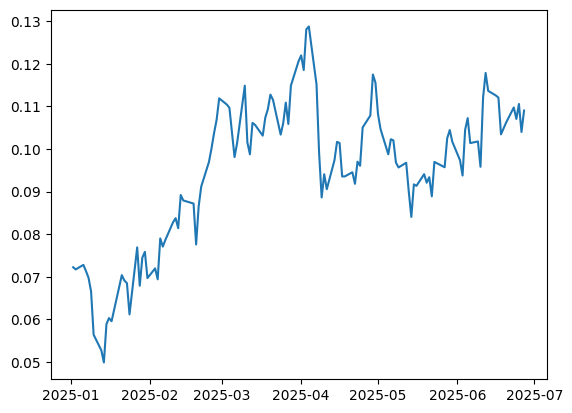

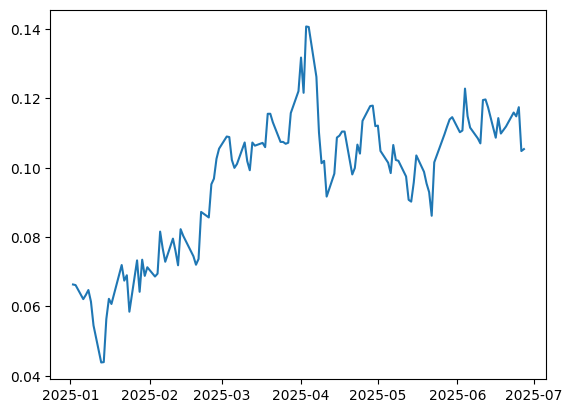

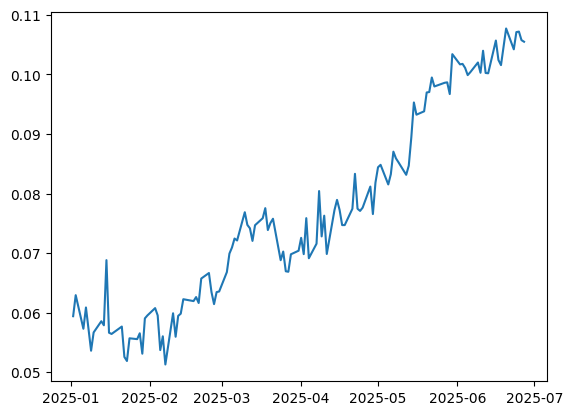

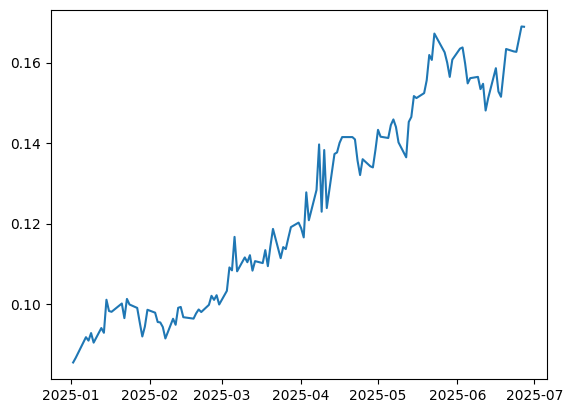

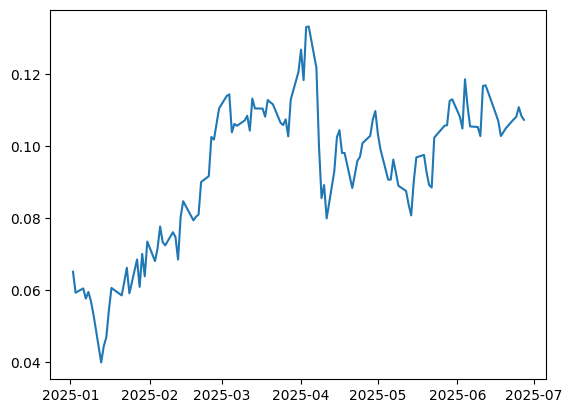

In [6]:
full_df = usts.get_initial_screening_set(curve_builder.bspline_model)

In [7]:
yields, prices = usts.get_cusip_timeseries(CUSIPs=['912810RB6', '912810SR0'],
                          start_date=datetime.date(2025, 1, 1),
                          end_date=datetime.date(2025, 6, 26))
yields

,912810SR0,912810RB6,Spread
Date,,,
2025-01-02,4.815346,4.887568,0.072222
2025-01-03,4.844384,4.916093,0.071709
2025-01-06,4.868426,4.941197,0.072771
2025-01-07,4.935901,5.007236,0.071335
2025-01-08,4.941097,5.010854,0.069757
...,...,...,...
2025-06-20,4.817287,4.923479,0.106192
2025-06-23,4.782582,4.892318,0.109736
2025-06-24,4.748045,4.855084,0.107039


<Axes: xlabel='Date'>

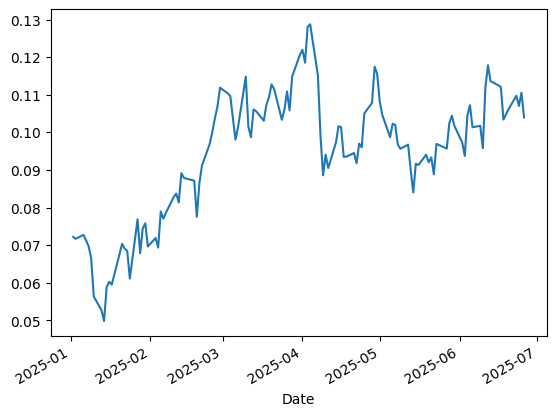

In [8]:
yields['Spread'].plot()